In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CS231_Project/CS231/'

/content/drive/.shortcut-targets-by-id/114eZwEq3ssNUlhhIkvQ6Aae2tJKSGuUS/CS231


In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 3s (1,717 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like

In [ ]:
!which tesseract

/usr/bin/tesseract


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/78.2 GB disk)


In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="0PwdcMNJxaSn5xnzHKp2")
# project = rf.workspace("uit-ze0fr").project("cs231-ddyhg")
# dataset = project.version(1).download("yolov8")

In [ ]:
import os
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import pytesseract
try:
 from PIL import Image
except ImportError:
 import Image

# Train and validate model

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data={'/content/drive/MyDrive/CS231_Project/CS231/CS231-2'}/data.yaml epochs=100 imgsz=640

In [ ]:
!yolo task=detect mode=val model='/content/drive/MyDrive/CS231_Project/CS231/runs/detect/train5/weights/best.pt' data={'/content/drive/MyDrive/CS231_Project/CS231/CS231-2'}/data.yaml

# Test

In [ ]:
model = YOLO('/content/drive/MyDrive/CS231_Project/CS231/runs/detect/train5/weights/best.pt')
test_folder = '/content/drive/MyDrive/CS231_Project/CS231/CS231-2/test/images'

for filename in os.listdir(test_folder):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        image_path = os.path.join(test_folder, filename)
        res = model(image_path)
        res_plotted = res[0].plot()
        cv2_imshow(res_plotted)


# Read plate using Tesseract OCR

In [ ]:
model = YOLO('/content/drive/MyDrive/CS231_Project/CS231/runs/detect/train5/weights/best.pt')


0: 320x640 1 BienSoXe, 79.3ms
Speed: 3.1ms preprocess, 79.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


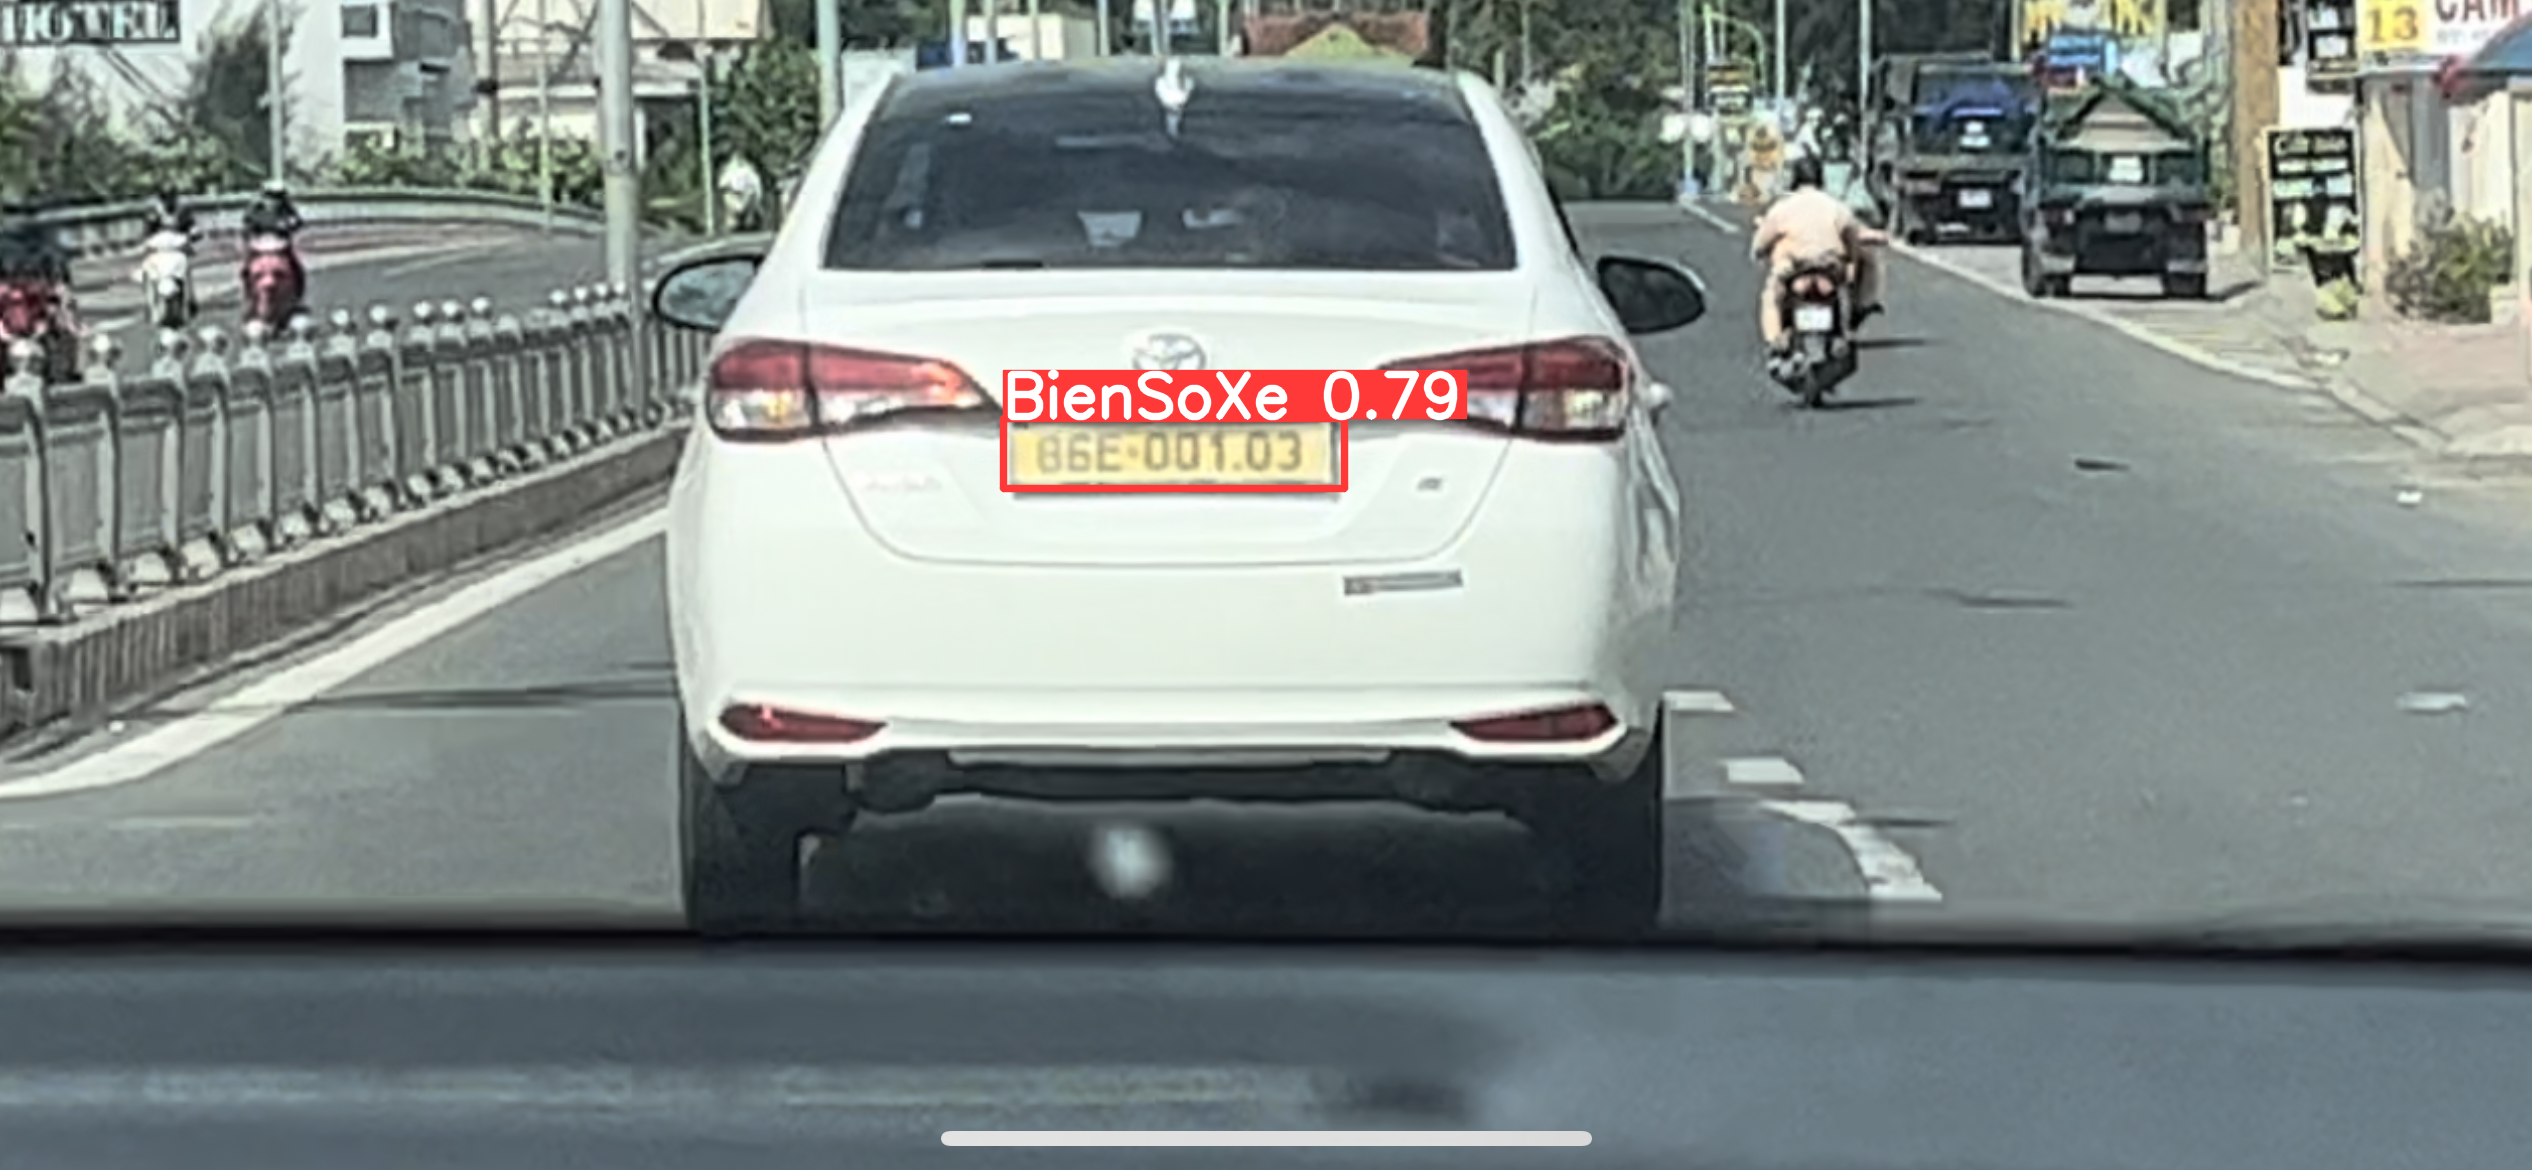

In [ ]:
# img = cv.imread('/content/drive/MyDrive/CS231_Project/CS231/CS231-2/test/images/89A15530.jpg')
img = cv.imread('/content/drive/MyDrive/CS231_Project/images/IMG_6409.PNG')
res = model(img)
res_plotted = res[0].plot()
cv2_imshow(res_plotted)

In [ ]:
t = res[0].boxes.xyxy
t1 = t.cpu().numpy()
x = int(t1[0][0])
y = int(t1[0][1])
x1 = int(t1[0][2])
y1 = int(t1[0][3])

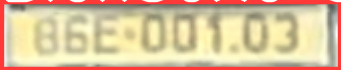

In [ ]:
# img = cv.imread('/content/drive/MyDrive/CS231_Project/images/test.jpg')
cropped_img = res_plotted[y:y1, x:x1]
cv2_imshow(cropped_img)

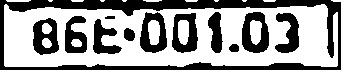

In [ ]:
gray = cv.cvtColor(cropped_img, cv.COLOR_BGR2GRAY)
blur = cv.medianBlur(gray, 3)
cropped_img = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 31, 2)
cv2_imshow(cropped_img)

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [ ]:
text = pytesseract.image_to_string(cropped_img, lang="eng", config="--psm 7")
text

'86£:001.03\n\x0c'

In [ ]:
char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ'
def fine_tune(lp):
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString

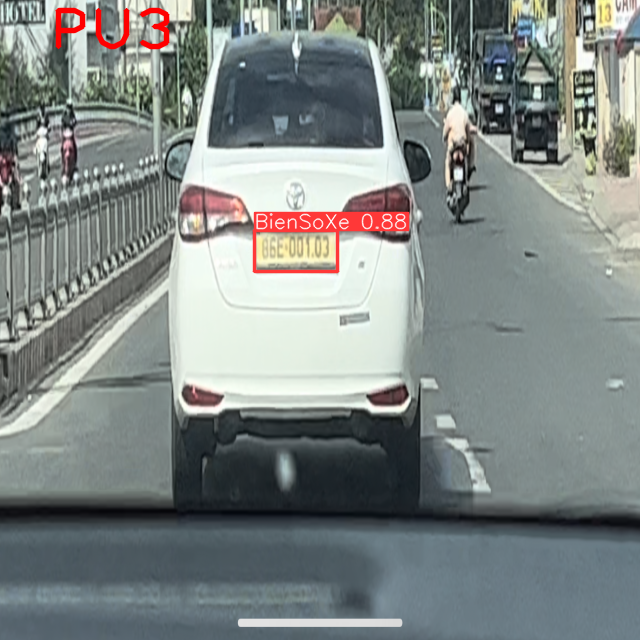

In [ ]:
cv.putText(res_plotted,fine_tune(text),(50, 50), cv.FONT_HERSHEY_PLAIN, 4.0, (0, 0, 255), 4, lineType=cv.LINE_AA)
cv2_imshow(res_plotted)

# Loop to calculate accuracy

In [ ]:
def compare(predicted, ground_truth):
    m = len(ground_truth)
    n = len(predicted)

    if m == 0:
        return 0  # Nếu không có kí tự trong ground_truth, trả về độ chính xác là 0

    excess_chars = max(n - m, 0)  # Số kí tự thừa là max(n - m, 0)

    # Tạo ma trận độ dài LCS
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Tính toán độ dài LCS
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ground_truth[i - 1] == predicted[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs_length = dp[m][n]

    accuracy = (lcs_length / m) * 100
    return accuracy

In [ ]:
# Ham sap xep contour tu trai sang phai
def sort_contours(cnts):
    reverse = False
    i = 0
    boundingBoxes = [cv.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ'
def fine_tune(lp):
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString

# Load model SVM
model_svm = cv.ml.SVM_load('svm.xml')
model_knn = cv.ml.KNearest.load("knn_1.xml")
# Cau hinh tham so cho model SVM
digit_w = 30 # Kich thuoc ki tu
digit_h = 60 # Kich thuoc ki tu
model = YOLO('/content/drive/MyDrive/CS231_Project/CS231/runs/detect/train5/weights/best.pt')
# Đường dẫn ảnh, các bạn đổi tên file tại đây để thử nhé
path = "/content/drive/MyDrive/CS231_Project/CS231/CS231-2/test/images/"
# Khởi tạo biến accuracy
accuracy_svm = 0
accuracy_knn = 0
accuracy_ocr = 0
# Begin loop
for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        img_path = os.path.join(path, filename)
        img = cv.imread(img_path)
        res = model(img)
        res_plotted = res[0].plot()
        t = res[0].boxes.xyxy
        t1 = t.cpu().numpy()
        if not t1.any():
            continue
        x = int(t1[0][0])
        y = int(t1[0][1])
        x1 = int(t1[0][2])
        y1 = int(t1[0][3])
        cropped_img = res_plotted[y:y1, x:x1]
        cropped_img = cv.resize(cropped_img, (470, 110))
        roi = cropped_img
        gray = cv.cvtColor(cropped_img, cv.COLOR_BGR2GRAY)
        blur = cv.medianBlur(gray, 3)
        binary = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 31, 2)

        cropped_img = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 31, 2)
        predict_ocr = pytesseract.image_to_string(cropped_img, lang="eng", config="--psm 7")
        predict_ocr = fine_tune(predict_ocr)

        # Segment kí tự
        kernel3 = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
        thre_mor = cv.morphologyEx(binary, cv.MORPH_DILATE, kernel3)
        thre_mor = cv.morphologyEx(thre_mor, cv.MORPH_OPEN, kernel3)
        thre_mor = cv.morphologyEx(thre_mor, cv.MORPH_CLOSE, kernel3)
        cont, _  = cv.findContours(thre_mor, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        predict_svm = ''
        predict_knn = ''
        for c in sort_contours(cont):
            (x, y, w, h) = cv.boundingRect(c)
            ratio = h/w
            if 1<=ratio<=3.5: # Chon cac contour dam bao ve ratio w/h
                if h/roi.shape[0]>=0.55: # Chon cac contour cao tu 55% bien so tro len
                    # Ve khung chu nhat quanh so
                    cv.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Tach so va predict
                    curr_num = thre_mor[y:y+h,x:x+w]
                    curr_num = cv.resize(curr_num, dsize=(digit_w, digit_h))
                    _, curr_num = cv.threshold(curr_num, 30, 255, cv.THRESH_BINARY)
                    curr_num = np.array(curr_num,dtype=np.float32)
                    curr_num = curr_num.reshape(-1, digit_w * digit_h)

                    # Dua vao model SVM
                    result_svm = model_svm.predict(curr_num)[1]
                    result_svm = int(result_svm[0, 0])
                    # Dua vao model KNN
                    result_knn = model_knn.findNearest(curr_num, k=1)[1]
                    result_knn = int(result_knn[0, 0])

                    if result_svm <= 9: # Neu la so thi hien thi luon
                        result_svm = str(result_svm)
                    else: #Neu la chu thi chuyen bang ASCII
                        result_svm = chr(result_svm)

                    if result_knn <= 9: # Neu la so thi hien thi luon
                        result_knn = str(result_knn)
                    else: #Neu la chu thi chuyen bang ASCII
                        result_knn = chr(result_knn)

                    predict_svm += result_svm
                    predict_knn += result_knn
        label = os.path.splitext(filename)[0].replace(' (1)', '').replace(' (2)', '')
        acc_svm = compare(predict_svm, label)
        acc_knn = compare(predict_knn, label)
        acc_ocr = compare(predict_ocr, label)
        accuracy_svm += acc_svm
        accuracy_knn += acc_knn
        accuracy_ocr += acc_ocr
        # cv2_imshow(roi)
        print('Predict of svm: ', predict_svm)
        print('Predict of knn: ', predict_knn)
        print('Predict of ocr: ', predict_ocr)
        print('Label: ', label)
        print('Accuracy of svm: ', acc_svm)
        print('Accuracy of knn: ', acc_knn)
        print('Accuracy of ocr: ', acc_ocr)
        print('\n')
accuracy_svm = accuracy_svm / 129
accuracy_knn = accuracy_knn / 129
accuracy_ocr = accuracy_ocr / 129
print('Accuracy of svm: ', accuracy_svm)
print('Accuracy of knn: ', accuracy_knn)
print('Accuracy of ocr: ', accuracy_ocr)


0: 640x640 1 BienSoXe, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 21.2ms
Speed: 2.8ms preprocess, 21.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  51F88270
Label:  51F88270
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 8.8ms
Speed: 1.9ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  51047281
Predict of knn:  51047281
Predict of ocr:  
Label:  51G47281
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  0.0


Predict of svm:  61E15585
Predict of knn:  61E16585
Predict of ocr:  51F15585
Label:  51F15585
Accuracy of svm:  75.0
Accuracy of knn:  62.5
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.6ms
Speed: 3.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  04
Predict of knn:  04
Predict of ocr:  60L000584
Label:  60LD00584
Accuracy of svm:  22.22222222222222
Accuracy of knn:  22.22222222222222
Accuracy of ocr:  88.88888888888889


Predict of svm:  A
Predict of knn:  A
Predict of ocr:  GA21418
Label:  60A21418
Accuracy of svm:  12.5
Accuracy of knn:  12.5
Accuracy of ocr:  75.0




0: 640x640 1 BienSoXe, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  
Predict of knn:  
Predict of ocr:  151G39466
Label:  51G39466
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0


Predict of svm:  86A06844
Predict of knn:  86A06844
Predict of ocr:  86A06844
Label:  86A06844
Accuracy of svm:  100.0
Accuracy of knn:  100.0
Accuracy of ocr:  100.0




0: 640x640 1 BienSoXe, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  8318S
Predict of knn:  0310S
Predict of ocr:  ZG3633GS
Label:  ZG633GS
Accuracy of svm:  28.57142857142857
Accuracy of knn:  28.57142857142857
Accuracy of ocr:  100.0


Predict of svm:  51047340
Predict of knn:  51047340
Predict of ocr:  
Label:  51G47340
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  Z65
Predict of knn:  Z00
Predict of ocr:  762409951
Label:  ZG4699T
Accuracy of svm:  28.57142857142857
Accuracy of knn:  14.285714285714285
Accuracy of ocr:  42.857142857142854


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  ZG660UU
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0




0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  SS461N
Label:  ZG9461N
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  57.14285714285714


Predict of svm:  Z69038L
Predict of knn:  Z08038L
Predict of ocr:  7629039L
Label:  ZG9039L
Accuracy of svm:  71.42857142857143
Accuracy of knn:  57.14285714285714
Accuracy of ocr:  71.42857142857143





0: 640x640 1 BienSoXe, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  Z858M
Predict of knn:  Z0684
Predict of ocr:  768941N
Label:  ZG8941N
Accuracy of svm:  28.57142857142857
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  71.42857142857143





0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  5D226H
Predict of knn:  0U22HH
Predict of ocr:  2624499AD
Label:  ZG4499AD
Accuracy of svm:  12.5
Accuracy of knn:  0.0
Accuracy of ocr:  75.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  51F26403
Label:  51F24403
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5




0: 640x640 1 BienSoXe, 8.4ms
Speed: 2.4ms preprocess, 8.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  Z83MU
Predict of knn:  Z034U
Predict of ocr:  2623428
Label:  ZG3428J
Accuracy of svm:  28.57142857142857
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  57.14285714285714





0: 640x640 1 BienSoXe, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  Z8M2M8H
Predict of knn:  Z04240H
Predict of ocr:  2G62424GH
Label:  ZG424GH
Accuracy of svm:  42.857142857142854
Accuracy of knn:  71.42857142857143
Accuracy of ocr:  85.71428571428571


Predict of svm:  Z8260X
Predict of knn:  Z0266X
Predict of ocr:  762216K
Label:  ZG216TK
Accuracy of svm: 


0: 640x640 1 BienSoXe, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  57.14285714285714


Predict of svm:  ST377E
Predict of knn:  ST377E
Predict of ocr:  ST3771E
Label:  ST377IE
Accuracy of svm:  85.71428571428571
Accuracy of knn:  85.71428571428571
Accuracy of ocr:  85.71428571428571





0: 640x640 1 BienSoXe, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  V8K
Predict of knn:  V8K
Predict of ocr:  BVU318AK
Label:  VU318AK
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  100.0


Predict of svm:  359
Predict of knn:  358
Predict of ocr:  DE8359M
Label:  DE359M
Accuracy of svm:  50.0
Accuracy of knn:  33.33333333333333
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  M
Predict of knn:  4
Predict of ocr:  K22425V
Label:  KZ425V
Accuracy of svm:  0.0
Accuracy of knn:  16.666666666666664
Accuracy of ocr:  83.33333333333334


Predict of svm:  01
Predict of knn:  HX
Predict of ocr:  7627499A
Label:  ZG7499AJ
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  62.5





0: 640x640 1 BienSoXe, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  83878C
Predict of knn:  83878C
Predict of ocr:  B8818CN
Label:  BJ818CN
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  85.71428571428571


Predict of svm:  55C
Predict of knn:  55C
Predict of ocr:  R15451C
Label:  RI545IC
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  71.42857142857143




0: 640x640 1 BienSoXe, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  2G22462AE
Label:  ZG2462AE
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  FM6547X
Predict of knn:  FH0547Y
Predict of ocr:  VFNG54718
Label:  FMG547
Accuracy of svm:  83.33333333333334
Accuracy of knn:  66.66666666666666
Accuracy of ocr:  83.33333333333334


Predict of svm:  FFU20D4
Predict of knn:  FFU1004
Predict of ocr:  HESFU1004
Label:  FFU1004
Accuracy of svm:  71.42857142857143
Accuracy of knn:  100.0
Accuracy of ocr:  85.71428571428571





0: 640x640 1 BienSoXe, 7.4ms
Speed: 3.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  05KC
Predict of knn:  00KC
Predict of ocr:  R580KC
Label:  RI580KC
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  85.71428571428571


Predict of svm:  Z6DP
Predict of knn:  Z0DP
Predict of ocr:  262293P
Label:  ZG293P
Accuracy of svm:  33.33333333333333
Accuracy of knn:  33.33333333333333
Accuracy of ocr:  66.66666666666666





0: 640x640 1 BienSoXe, 7.6ms
Speed: 2.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  Z65805
Predict of knn:  Z05600
Predict of ocr:  7625670
Label:  ZG5670I
Accuracy of svm:  42.857142857142854
Accuracy of knn:  57.14285714285714
Accuracy of ocr:  57.14285714285714


Predict of svm: 


0: 640x640 1 BienSoXe, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)



 6MD56U
Predict of knn:  04000U
Predict of ocr:  762474DU
Label:  ZG474DU
Accuracy of svm:  28.57142857142857
Accuracy of knn:  28.57142857142857
Accuracy of ocr:  71.42857142857143


Predict of svm:  VU27K
Predict of knn:  VU27K
Predict of ocr:  VU2271K
Label:  VU271K
Accuracy of svm:  83.33333333333334
Accuracy of knn:  83.33333333333334
Accuracy of ocr:  100.0




0: 640x640 1 BienSoXe, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  Z02M24
Predict of knn:  Z02424
Predict of ocr:  7G22424B
Label:  ZG2424B
Accuracy of svm:  57.14285714285714
Accuracy of knn:  71.42857142857143
Accuracy of ocr:  85.71428571428571


Predict of svm:  Z6888VF
Predict of knn:  Z0V68VF
Predict of ocr:  72G62679VF
Label:  ZG679VF
Accuracy of svm:  57.14285714285714
Accuracy of knn:  57.14285714285714
Accuracy of ocr:  85.71428571428571




0: 640x640 1 BienSoXe, 8.4ms
Speed: 2.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  005HH2
Predict of knn:  00ZH33
Predict of ocr:  FKA596C
Label:  KA596CJ
Accuracy of svm:  14.285714285714285
Accuracy of knn:  0.0
Accuracy of ocr:  85.71428571428571


Predict of svm:  Z80530
Predict of knn:  Z00010
Predict of ocr:  1621010
Label:  ZG21010
Accuracy of svm:  42.857142857142854
Accuracy of knn:  57.14285714285714
Accuracy of ocr:  71.42857142857143





0: 640x640 1 BienSoXe, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  Z0MCC
Predict of knn:  ZG4CC
Predict of ocr:  2G401CC
Label:  ZG401CC
Accuracy of svm:  57.14285714285714
Accuracy of knn:  71.42857142857143
Accuracy of ocr:  85.71428571428571


Predict of svm:  Z078M8AD
Predict of knn:  Z07849AD
Predict of ocr:  7627949AD
Label:  ZG7949AD
Accuracy of svm:  50.0
Accuracy of knn:  75.0
Accuracy of ocr:  75.0





0: 640x640 1 BienSoXe, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  ZG20092D0
Predict of knn:  ZG2008200
Predict of ocr:  7620920
Label:  ZG20920
Accuracy of svm:  100.0
Accuracy of knn:  85.71428571428571
Accuracy of ocr:  71.42857142857143


Predict of svm:  Z68201
Predict of knn:  Z08200
Predict of ocr:  1621920T
Label:  ZG1920T
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  71.42857142857143





0: 640x640 1 BienSoXe, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  878L8
Predict of knn:  078LR
Predict of ocr:  ZG2781LR
Label:  ZG781LR
Accuracy of svm:  42.857142857142854
Accuracy of knn:  57.14285714285714
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  NK1
Predict of knn:  HL1
Predict of ocr:  7628010AF
Label:  ZG8010AF
Accuracy of svm:  12.5
Accuracy of knn:  12.5
Accuracy of ocr:  75.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  51G48154
Label:  51G48154
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0




0: 640x640 1 BienSoXe, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  88MB1
Predict of knn:  084B1
Predict of ocr:  7629043B
Label:  ZG9043B
Accuracy of svm:  14.285714285714285
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  71.42857142857143


Predict of svm:  
Predict of knn:  
Predict of ocr:  TN2P1BC6225
Label:  TN21BC6225
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  21BZ0768
Label:  TN21BZ0768
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  80.0


Predict of svm:  51F244D3
Predict of knn:  51F24403
Predict of ocr:  
Label:  51F24403
Accuracy of svm:  87.5
Accuracy of knn:  100.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.8ms
Speed: 3.4ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  FA212
Label:  BSMART2
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  28.57142857142857





0: 640x640 1 BienSoXe, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  BKP665
Label:  BKTP655
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  71.42857142857143





0: 640x640 1 BienSoXe, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  60A3598
Predict of knn:  60A3598
Predict of ocr:  60A23098
Label:  60A35981
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  75.0





0: 640x640 1 BienSoXe, 9.3ms
Speed: 1.8ms preprocess, 9.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  12
Predict of knn:  1X
Predict of ocr:  77A06546
Label:  47A06546
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  092B3HD
Predict of knn:  GB28UHB
Predict of ocr:  G526HD
Label:  G526JHD
Accuracy of svm:  42.857142857142854
Accuracy of knn:  42.857142857142854
Accuracy of ocr:  85.71428571428571





0: 640x640 1 BienSoXe, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  51F86988
Predict of knn:  51F86988
Predict of ocr:  51F86988
Label:  51F86988
Accuracy of svm:  100.0
Accuracy of knn:  100.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  T4
Label:  145
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  33.33333333333333





0: 640x640 1 BienSoXe, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  217
Predict of knn:  217
Predict of ocr:  151G21670
Label:  51G21670
Accuracy of svm:  37.5
Accuracy of knn:  37.5
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  MH20E0364
Label:  MH20EJ0364
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  90.0





0: 640x640 1 BienSoXe, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  DAN56P
Predict of knn:  DAN54P
Predict of ocr:  DAN54P
Label:  DAN54P
Accuracy of svm:  83.33333333333334
Accuracy of knn:  100.0
Accuracy of ocr:  100.0





0: 640x640 (no detections), 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 10.5ms
Speed: 3.7ms preprocess, 10.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  1039466
Predict of knn:  1039466
Predict of ocr:  151G239466
Label:  51G39466
Accuracy of svm:  75.0
Accuracy of knn:  75.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  A25
Predict of knn:  A26
Predict of ocr:  STA22909
Label:  61A22959
Accuracy of svm:  37.5
Accuracy of knn:  25.0
Accuracy of ocr:  62.5


Predict of svm:  
Predict of knn:  
Predict of ocr:  KAGSNG
Label:  KA05MG1909
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  30.0





0: 640x640 1 BienSoXe, 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  AG2UAR
Label:  JA62UAR
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  71.42857142857143


Predict of svm:  51513
Predict of knn:  51513
Predict of ocr:  51651332
Label:  51G51332
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  MH20EE7598
Label:  MH20EE7598
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  51A01204
Predict of knn:  51A01204
Predict of ocr:  151A01204
Label:  51A01204
Accuracy of svm:  100.0
Accuracy of knn:  100.0
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  890737
Label:  89A07379
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0




0: 640x640 1 BienSoXe, 7.5ms
Speed: 4.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 3.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30E47662
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  151F07973
Label:  51F07973
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  BALL
Label:  88A23016
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  12.5





0: 640x640 1 BienSoXe, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  51712
Predict of knn:  61712
Predict of ocr:  151F61712
Label:  51F61712
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  8908877
Label:  89A08877
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5




0: 640x640 1 BienSoXe, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  51E1615
Predict of knn:  51E1615
Predict of ocr:  151F216159
Label:  51F16159
Accuracy of svm:  75.0
Accuracy of knn:  75.0
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  LB8LD00275
Label:  89LD00275
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  88.88888888888889




0: 640x640 1 BienSoXe, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30F86574
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  F86402
Label:  30F86404
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  62.5




0: 640x640 1 BienSoXe, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  AN83605
Label:  30F83605
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  62.5


Predict of svm:  30E6122
Predict of knn:  30E6122
Predict of ocr:  30566122
Label:  30E66122
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  29H23855
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0


Predict of svm:  71
Predict of knn:  7Y
Predict of ocr:  A0E20707
Label:  30E20701
Accuracy of svm:  25.0
Accuracy of knn:  12.5
Accuracy of ocr:  75.0





0: 640x640 1 BienSoXe, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  51FT5585
Predict of knn:  51F155B5
Predict of ocr:  
Label:  51F15585
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  0.0


Predict of svm:  30E3064D
Predict of knn:  30E30840
Predict of ocr:  LANE30640
Label:  30E30640
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  75.0





0: 640x640 1 BienSoXe, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  1
Predict of knn:  Y
Predict of ocr:  30A17831
Label:  30A17831
Accuracy of svm:  12.5
Accuracy of knn:  0.0
Accuracy of ocr:  100.0


Predict of svm:  51A772
Predict of knn:  61A772
Predict of ocr:  
Label:  51A77529
Accuracy of svm:  75.0
Accuracy of knn:  62.5
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  29H77
Predict of knn:  29H77
Predict of ocr:  
Label:  29H06737
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  51F5988
Label:  51F59881
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  3052639
Label:  30S2639
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  85.71428571428571


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30A89685
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  79C82596
Label:  29C82506
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  30F72929
Label:  30F72929
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  GA20880
Label:  60A20880
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30F65939
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  30019185
Predict of knn:  30019185
Predict of ocr:  30619185
Label:  30G19185
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  87.5


Predict of svm:  
Predict of knn:  
Predict of ocr:  L39317888
Label:  89A17888
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0




0: 640x640 1 BienSoXe, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  30011Y55
Predict of knn:  30011Y55
Predict of ocr:  30G611155
Label:  30G11155
Accuracy of svm:  75.0
Accuracy of knn:  75.0
Accuracy of ocr:  100.0


Predict of svm:  51F590Y1
Predict of knn:  51F590VT
Predict of ocr:  
Label:  51F59011
Accuracy of svm:  87.5
Accuracy of knn:  75.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  
Predict of knn:  
Predict of ocr:  B8A03336
Label:  88A03336
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5


Predict of svm:  531
Predict of knn:  631
Predict of ocr:  51G31691
Label:  51G31691
Accuracy of svm:  37.5
Accuracy of knn:  25.0
Accuracy of ocr:  100.0




0: 640x640 1 BienSoXe, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  2H157
Predict of knn:  2H167
Predict of ocr:  29H15079
Label:  29H15079
Accuracy of svm:  62.5
Accuracy of knn:  50.0
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  89475530
Label:  89A15530
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0




0: 640x640 1 BienSoXe, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  51E3YT18
Predict of knn:  51F3YT18
Predict of ocr:  
Label:  51F31118
Accuracy of svm:  62.5
Accuracy of knn:  75.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  30F97025
Predict of knn:  30F97025
Predict of ocr:  30F97025
Label:  30F97025
Accuracy of svm:  100.0
Accuracy of knn:  100.0
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30F44101
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  5F
Predict of knn:  6F
Predict of ocr:  
Label:  51F06532
Accuracy of svm:  25.0
Accuracy of knn:  12.5
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  62A05772
Label:  62A05772
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0




0: 640x640 1 BienSoXe, 10.2ms
Speed: 3.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  51F86988
Label:  51F86988
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  100.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  5
Label:  30A44035
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  12.5





0: 640x640 1 BienSoXe, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  512177
Predict of knn:  512177
Predict of ocr:  
Label:  51G21797
Accuracy of svm:  75.0
Accuracy of knn:  75.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  K33254
Predict of knn:  K33254
Predict of ocr:  83433254
Label:  99A33254
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  62.5


Predict of svm:  F
Predict of knn:  F
Predict of ocr:  STES8
Label:  51F31118
Accuracy of svm:  12.5
Accuracy of knn:  12.5
Accuracy of ocr:  12.5




0: 640x640 1 BienSoXe, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



Predict of svm:  4A277
Predict of knn:  4A277
Predict of ocr:  
Label:  34A20477
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  RE20449
Label:  30F20449
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  62.5




0: 640x640 1 BienSoXe, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  1BA728
Predict of knn:  18A726
Predict of ocr:  18A07826
Label:  18A07826
Accuracy of svm:  50.0
Accuracy of knn:  75.0
Accuracy of ocr:  100.0


Predict of svm:  A451
Predict of knn:  A451
Predict of ocr:  
Label:  29A46511
Accuracy of svm:  50.0
Accuracy of knn:  50.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  30M4703
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  S03316
Label:  30G03916
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  50.0





0: 640x640 1 BienSoXe, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 7.6ms


Predict of svm:  
Predict of knn:  
Predict of ocr:  23K02343
Label:  29A02343
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0


Predict of svm:  
Predict of knn:  
Predict of ocr:  50UD0L411
Label:  50LD04411
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  77.77777777777779




Speed: 3.3ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 BienSoXe, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  5A
Predict of knn:  5A
Predict of ocr:  51A00530
Label:  51A00530
Accuracy of svm:  25.0
Accuracy of knn:  25.0
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  D39
Predict of knn:  D39
Predict of ocr:  51010039
Label:  51D10039
Accuracy of svm:  37.5
Accuracy of knn:  37.5
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  5F797
Predict of knn:  5P797
Predict of ocr:  
Label:  51F07973
Accuracy of svm:  62.5
Accuracy of knn:  50.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  77
Predict of knn:  77
Predict of ocr:  
Label:  51G27471
Accuracy of svm:  25.0
Accuracy of knn:  25.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  5F88270
Label:  51F88270
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  5YA77529
Predict of knn:  5YA77529
Predict of ocr:  1A277529
Label:  51A77529
Accuracy of svm:  87.5
Accuracy of knn:  87.5
Accuracy of ocr:  87.5





0: 640x640 1 BienSoXe, 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  
Label:  51A85325
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  0.0





0: 640x640 1 BienSoXe, 11.4ms
Speed: 3.1ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  5TET5585
Predict of knn:  5TET5585
Predict of ocr:  51F15585
Label:  51F15585
Accuracy of svm:  62.5
Accuracy of knn:  62.5
Accuracy of ocr:  100.0





0: 640x640 1 BienSoXe, 8.7ms
Speed: 7.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Predict of svm:  
Predict of knn:  
Predict of ocr:  BF22029
Label:  51F22029
Accuracy of svm:  0.0
Accuracy of knn:  0.0
Accuracy of ocr:  75.0


Predict of svm:  F
Predict of knn:  F
Predict of ocr:  51F6L619
Label:  51F646419
Accuracy of svm:  11.11111111111111
Accuracy of knn:  11.11111111111111
Accuracy of ocr:  77.77777777777779


Accuracy of svm:  33.01956441491325
Accuracy of knn:  33.53174603174603
Accuracy of ocr:  65.26854928017717
